In [1]:
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU
from keras.layers import Activation, Flatten, Dense, Reshape,Input
from keras.models import Model
from keras import backend as K
from keras.callbacks import EarlyStopping as ES

from tensorflow.keras.optimizers import Adam

from keras import objectives
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
class Autoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32,64), latentDim=16):
        inputShape=(height, width, depth)
        chanDim=-1
        inputs=Input(shape=inputShape)
        x=inputs
        for f in filters:
            x=Conv2D(f, (3,3), strides=2, padding='same')(x)
            x=LeakyReLU(alpha=0.2)(x)
            x=BatchNormalization(axis=chanDim)(x)
        
        volumeSize=K.int_shape(x)
        x=Flatten()(x)
        latent=Dense(latentDim)(x)
        
        encoder= Model(inputs, latent,name='encoder')
        
        latentInputs=Input(shape=(latentDim,))
        x=Dense(np.prod(volumeSize[1:]))(latentInputs)
        x=Reshape((volumeSize[1], volumeSize[2],volumeSize[3]))(x)
        for f in filters[::-1]:
            x=Conv2DTranspose(f,(3,3),strides=2,padding='same')(x)
            x=LeakyReLU(alpha=0.2)(x)
            x=BatchNormalization(axis=chanDim)(x)
            
        x=Conv2DTranspose(depth, (3,3),padding='same')(x)
        outputs=Activation('sigmoid')(x)
        decoder=Model(latentInputs, outputs, name='decoder')
        autoencoder=Model(inputs, decoder(encoder(inputs)),name='autoencoder')
        return (encoder, decoder, autoencoder)
            
        


4423680/4422102 [==============================] - 1s 0us/step


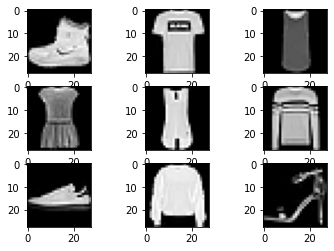

In [3]:
def plot(trainx):
    for i in range(9):
        plt.subplot(330+1+i)
        plt.imshow(trainx[i], cmap=plt.get_cmap('gray'))
    plt.show()

EPOCHS=25
BS=32
samples=8

(trainx, trainy), (testx, testy)=fashion_mnist.load_data()

trainx=trainx.reshape((trainx.shape[0], 28,28,1))
testx=testx.reshape((testx.shape[0], 28,28,1))

trainx= trainx.astype('float32')/255.0
testx= testx.astype('float32')/255.0
    
plot(trainx)

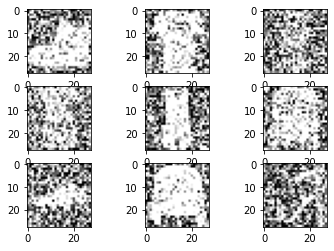

In [4]:
train_noise=np.random.normal(loc=0.5,scale=0.5,size=trainx.shape)
testNoise=np.random.normal(loc=0.5, scale=0.5, size=testx.shape)
trainx_noisy=np.clip(trainx+train_noise, 0., 1.)
testx_noisy=np.clip(testx+testNoise,0.,1.)
plot(trainx_noisy)

In [5]:
# constructing conv autoencoder
(encoder, decoder, autoencoder)=Autoencoder.build(28,28,1)
opt=Adam(lr=1e-3)
autoencoder.compile(loss='mse',optimizer=opt)
callback=ES(monitor='loss',min_delta=0.001,patience=3)

H=autoencoder.fit(
    trainx_noisy,trainx,
    validation_data=(testx_noisy, testx),
    epochs=EPOCHS,
    batch_size=BS,callbacks=callback)

Epoch 1/25
1875/1875 [==============================] - 196s 104ms/step - loss: 0.0240 - val_loss: 0.0190
Epoch 2/25
1875/1875 [==============================] - 215s 115ms/step - loss: 0.0187 - val_loss: 0.0182
Epoch 3/25
1875/1875 [==============================] - 172s 92ms/step - loss: 0.0179 - val_loss: 0.0179
Epoch 4/25
1875/1875 [==============================] - 170s 91ms/step - loss: 0.0174 - val_loss: 0.0186
Epoch 5/25
1875/1875 [==============================] - 184s 98ms/step - loss: 0.0171 - val_loss: 0.0171
Epoch 6/25
1875/1875 [==============================] - 168s 90ms/step - loss: 0.0169 - val_loss: 0.0184
Epoch 7/25
1875/1875 [==============================] - 169s 90ms/step - loss: 0.0167 - val_loss: 0.0170


In [6]:
# making predictions
decoded=autoencoder.predict(testx_noisy)
outputs=None
for i in range(0,samples):
    original=(testx_noisy[i]*255).astype('uint8')
    recon=(decoded[i]*255).astype('uint8')
    
    output=np.hstack([original, recon])
    if outputs is None:
        outputs=output
    else:
        outputs=np.vstack([outputs, output])
        
# plot(outputs)


In [8]:
# outputs.shape
cv2.imwrite("out_denoising_fashion.png",outputs)

True

In [9]:
autoencoder.save("dae_fashion")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: dae_fashion\assets
